# CCN Assignment 5: Reinforcement Learning
By: Luca Parolo & Emiel Stoelinga

In the current assignment, several reinforcement learning algorithms will be examined and implemented in a simple environment.

First basic libraries are imported.

In [154]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_env import EvidenceEnv

### Assignment 1
First, an agent is implemented which performs random actions given the observations.

In [139]:
class RandomAgent(object):
    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        self.env = env

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """
#         print(observation)
        action = np.random.choice(self.env.n_action)
#         print(action)
        return action

    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        pass

In [140]:
def run(env, agent, n_iter):
    # reset environment and agent
    obs = env.reset()
    reward = None
    done = False
    R = []
    for step in range(n_iter):
        env.render()
        action = agent.act(obs)
        _obs, reward, done, _ = env.step(action)
        agent.train(action, obs, reward, _obs)
        obs = _obs
        R.append(reward)
        
    return R

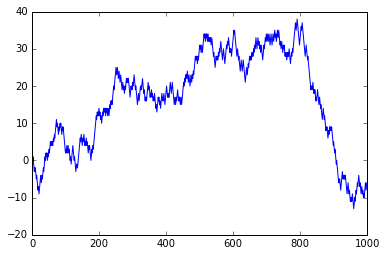

In [151]:
# Number of iterations
n_iter = 1000
# environment specs
env = EvidenceEnv(n=2, p=0.95)
# define agent
rndm_agent = RandomAgent(env)

reward = run(env, rndm_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(1)
plt.plot(reward_accumulated)    

### Assignment 2: Q-learning
In the second part of the assignment, a q-learning agent is implemented which predicts the action to chose based on observations and predicted reward.

In [166]:
class QLearnAgent(object):
    def __init__(self, env, alpha, lamb):
        self.env = env
        n_inputs = env.n_input
        n_actions = env.n_action
        self.q_table = np.zeros((2**n_inputs, n_actions))
        
        self.alpha = alpha
        self.lamb = lamb
        
    def act(self, observation):
#         Determine the index of the observation
        idx = self.env.asint(observation)
#         Determine the action with the maximum q-value for the
#         current observation
        action = np.argmax(self.q_table[idx])
        return action
    
    def train(self, a, old_obs, r, new_obs):
#         Determine the index of the observations
        old_idx = self.env.asint(old_obs)
        new_idx = self.env.asint(new_obs)
#         Return the maximum q-value of the new observation 
        fut_q = np.amax(self.q_table[new_idx])
        
#         Compute new q-values using the Bellman equation
        self.q_table[old_idx][a] = self.q_table[old_idx][a]+self.alpha*(r+self.lamb*fut_q-self.q_table[old_idx][a])

Table of start q-values
       Action 0  Action 1
[0,0]       0.0       0.0
[0,1]       0.0       0.0
[1,0]       0.0       0.0
[1,1]       0.0       0.0
Table of final q-values
       Action 0  Action 1
[0,0]  8.758082  0.000000
[0,1]  7.468513  0.000000
[1,0] -0.002816  8.879815
[1,1] -0.800000  8.669150


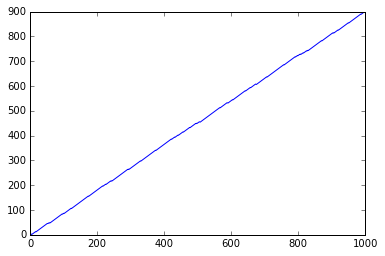

In [172]:
qlearn_agent = QLearnAgent(env, .8, .9)
old_qtable = pd.DataFrame(qlearn_agent.q_table, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))
print("Table of start q-values")
print(old_qtable)

reward = run(env, qlearn_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(2)
plt.plot(reward_accumulated)

new_qtable = pd.DataFrame(qlearn_agent.q_table, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))

print("Table of final q-values")
print(new_qtable)